# Predicting Future Energy Consumption

stacked LSTM model 
- https://www.researchgate.net/figure/Illustrations-for-basic-LSTMs-and-the-three-layer-stacked-LSTM-model-for-the-sequential_fig3_313115860
- https://stats.stackexchange.com/questions/163304/what-are-the-advantages-of-stacking-multiple-lstms
- https://machinelearningmastery.com/stacked-long-short-term-memory-networks/

# 1- Importing Key Modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import pprint
%matplotlib inline

In [3]:
# for deep learning
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

Using TensorFlow backend.


# 2- Loading and preparing Data


- https://www.kaggle.com/robikscube/hourly-energy-consumption
- Hourly Energy Consumption
- Over 10 years of hourly energy consumption data from PJM in Megawatts

In [4]:
df = pd.read_csv("AEP_hourly.csv")
df.shape

(121273, 2)

In [5]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [6]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
Datetime    121273 non-null object
AEP_MW      121273 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


- Datatime is not object. We need to convert it in correct format.
- We can also see there are no missing values

In [8]:
# double check
df.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

In [9]:
# data-time format
dataset = df
dataset["Month"] = pd.to_datetime(df["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["Datetime"]).dt.year
dataset["Date"] = pd.to_datetime(df["Datetime"]).dt.date
dataset["Time"] = pd.to_datetime(df["Datetime"]).dt.time
dataset["Week"] = pd.to_datetime(df["Datetime"]).dt.week
dataset["Day"] = pd.to_datetime(df["Datetime"]).dt.day_name()
dataset = df.set_index("Datetime")
dataset.index = pd.to_datetime(dataset.index)
dataset.head()

,AEP_MW,Month,Year,Date,Time,Week,Day
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,12,2004,2004-12-31,01:00:00,53,Friday
2004-12-31 02:00:00,12865.0,12,2004,2004-12-31,02:00:00,53,Friday
2004-12-31 03:00:00,12577.0,12,2004,2004-12-31,03:00:00,53,Friday
2004-12-31 04:00:00,12517.0,12,2004,2004-12-31,04:00:00,53,Friday
2004-12-31 05:00:00,12670.0,12,2004,2004-12-31,05:00:00,53,Friday


In [10]:
#Unique values of Year

print(df.Year.unique(),"\n")
print("Total Number of Unique Year", df.Year.nunique(), "\n")

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018] 

Total Number of Unique Year 15 



In this sequence, we do not have any missing value of year. They start from 2004 and end at 2018

# 3- Data Explortation

###3.1.energy consumption Each Year

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Energy Consumption According to Year')

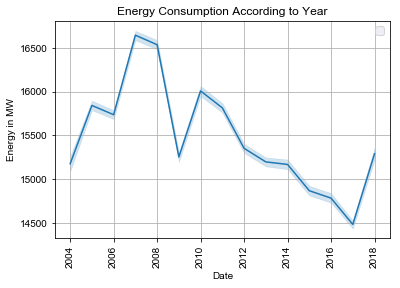

In [11]:
from matplotlib import style

fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

style.use('ggplot')

sns.lineplot(x=dataset["Year"], y=dataset["AEP_MW"], data=df)
sns.set(rc={'figure.figsize':(15,6)})

plt.title("Energy consumptionnin Year 2004")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)


plt.title("Energy Consumption According to Year")

###3.2.Energy consumption with date-vice

No handles with labels found to put in legend.


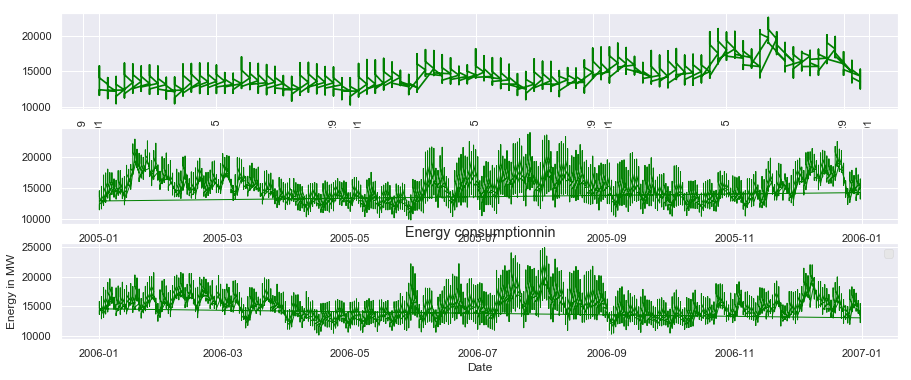

In [12]:
fig = plt.figure()

ax1= fig.add_subplot(311)
ax2= fig.add_subplot(312)
ax3= fig.add_subplot(313)


style.use('ggplot')

y_2004 = dataset["2004"]["AEP_MW"].to_list()
x_2004 = dataset["2004"]["Date"].to_list()
ax1.plot(x_2004,y_2004, color="green", linewidth=1.7)


y_2005 = dataset["2005"]["AEP_MW"].to_list()
x_2005 = dataset["2005"]["Date"].to_list()
ax2.plot(x_2005, y_2005, color="green", linewidth=1)


y_2006 = dataset["2006"]["AEP_MW"].to_list()
x_2006 = dataset["2006"]["Date"].to_list()
ax3.plot(x_2006, y_2006, color="green", linewidth=1)


plt.rcParams["figure.figsize"] = (18,8)
plt.title("Energy consumptionnin")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

### 3.3.Energy Distribution

Text(0.5, 1.0, 'Ennergy Distribution')

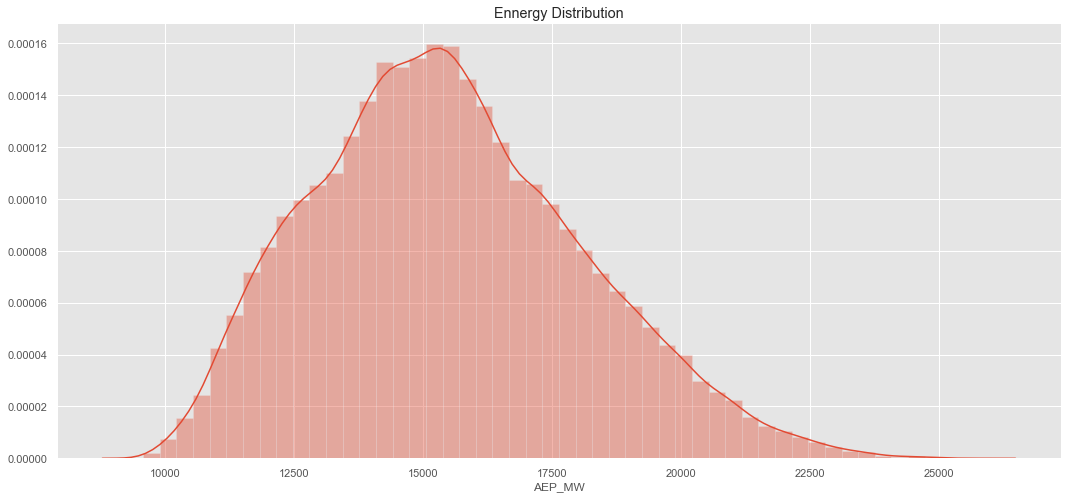

In [13]:
sns.distplot(dataset["AEP_MW"])
plt.title("Ennergy Distribution")

### 3.4.Energy with Respect to Time period

In [14]:
df.head()

,Datetime,AEP_MW,Month,Year,Date,Time,Week,Day
0,2004-12-31 01:00:00,13478.0,12,2004,2004-12-31,01:00:00,53,Friday
1,2004-12-31 02:00:00,12865.0,12,2004,2004-12-31,02:00:00,53,Friday
2,2004-12-31 03:00:00,12577.0,12,2004,2004-12-31,03:00:00,53,Friday
3,2004-12-31 04:00:00,12517.0,12,2004,2004-12-31,04:00:00,53,Friday
4,2004-12-31 05:00:00,12670.0,12,2004,2004-12-31,05:00:00,53,Friday


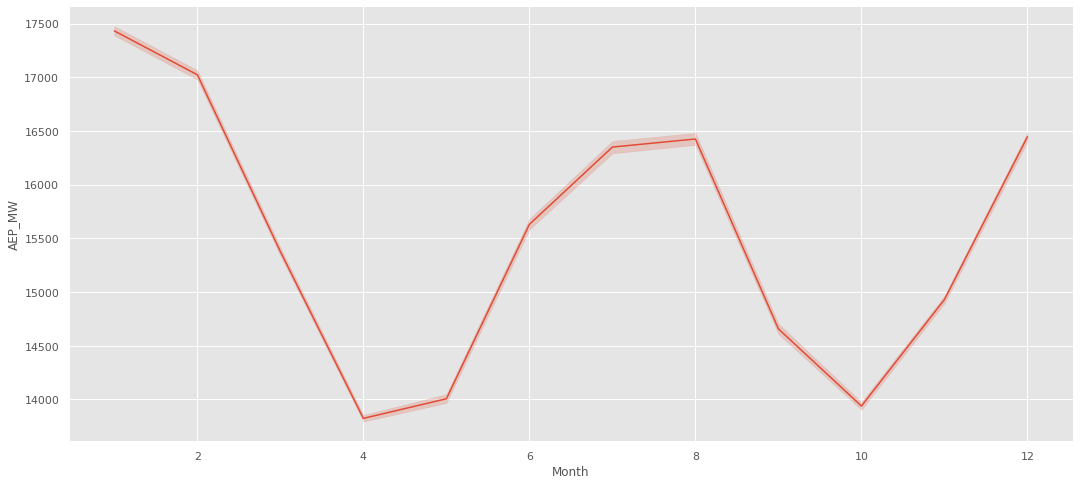

In [43]:
ax = sns.lineplot(x="Month", y="AEP_MW", data=df)

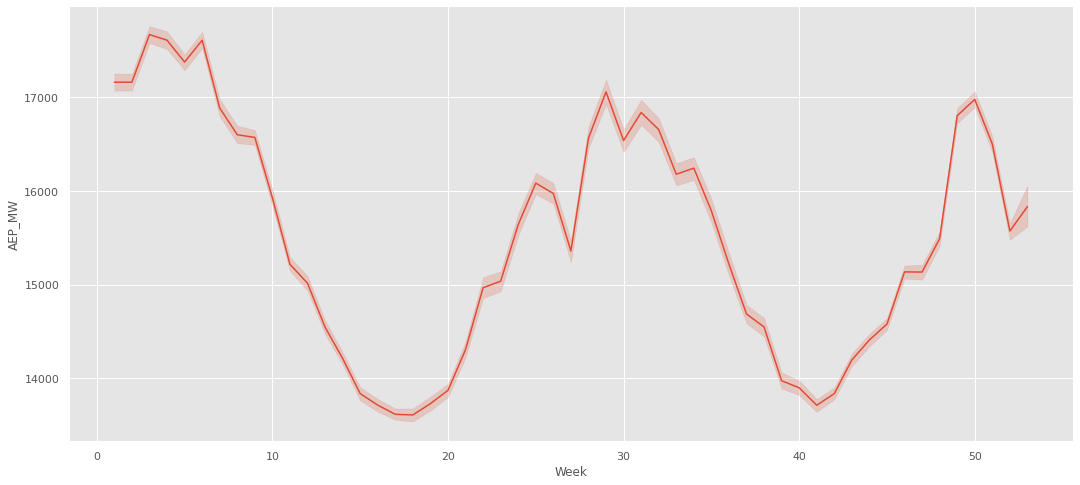

In [44]:
ax = sns.lineplot(x="Week", y="AEP_MW", data=df)

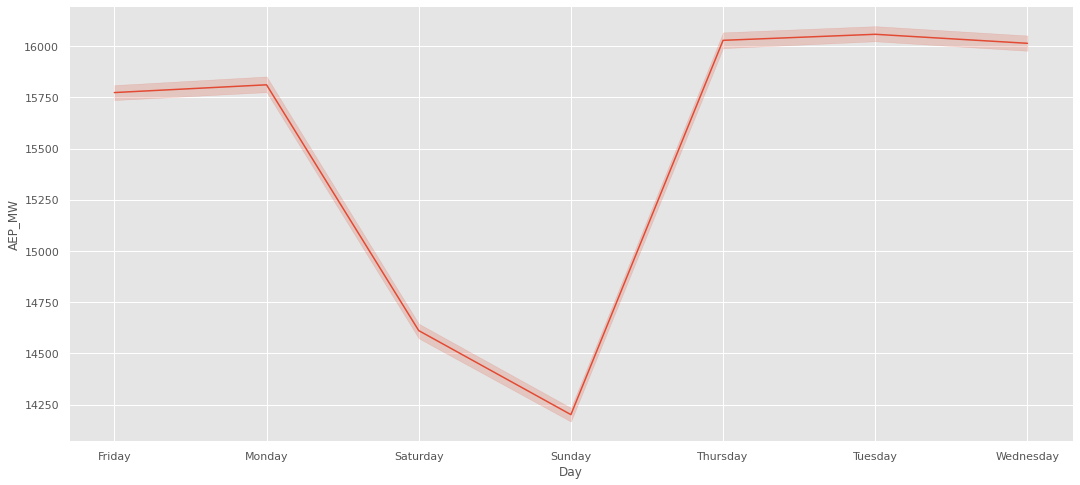

In [45]:
ax = sns.lineplot(x="Day", y="AEP_MW", data=df)

##### For time period

In [15]:
dataset.head()

,AEP_MW,Month,Year,Date,Time,Week,Day
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,12,2004,2004-12-31,01:00:00,53,Friday
2004-12-31 02:00:00,12865.0,12,2004,2004-12-31,02:00:00,53,Friday
2004-12-31 03:00:00,12577.0,12,2004,2004-12-31,03:00:00,53,Friday
2004-12-31 04:00:00,12517.0,12,2004,2004-12-31,04:00:00,53,Friday
2004-12-31 05:00:00,12670.0,12,2004,2004-12-31,05:00:00,53,Friday


In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 7 columns):
AEP_MW    121273 non-null float64
Month     121273 non-null int64
Year      121273 non-null int64
Date      121273 non-null object
Time      121273 non-null object
Week      121273 non-null int64
Day       121273 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 7.4+ MB


In [17]:
dataset["Time"]= dataset["Time"].astype(str)

In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 7 columns):
AEP_MW    121273 non-null float64
Month     121273 non-null int64
Year      121273 non-null int64
Date      121273 non-null object
Time      121273 non-null object
Week      121273 non-null int64
Day       121273 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 7.4+ MB


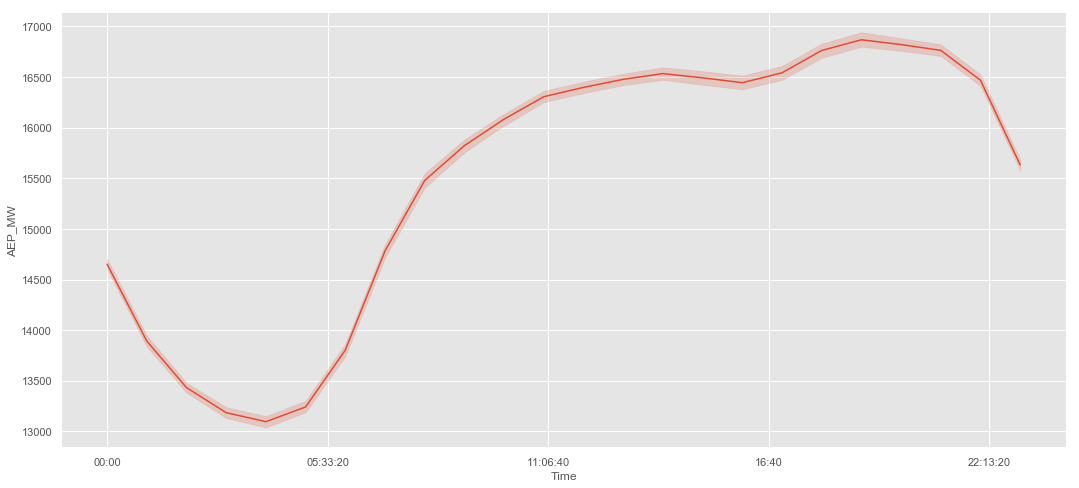

In [19]:
ax = sns.lineplot(x="Time", y="AEP_MW", data=df)

No handles with labels found to put in legend.


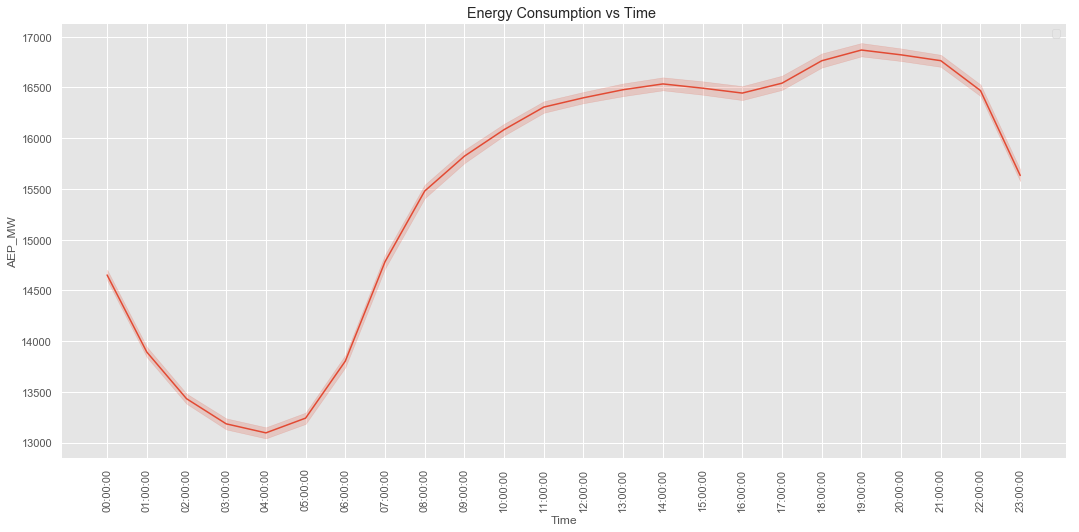

In [20]:
# more readable
fig = plt.figure()
ax1= fig.add_subplot(111)

sns.lineplot(x=dataset["Time"],y=dataset["AEP_MW"], data=df)
plt.title("Energy Consumption vs Time ")
plt.xlabel("Time")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

We can see energy consumption pattern throughout the day. All of these time period patterns i.e year, month,week, day ,daysofweek give us idea about energy consumption pattern. It can also be taken as consumer behavior on energy. Hence, dynamic pricing of energy can be adjusted accordingly by companies

# 4- Model Building

### Resampleing Data

Because we have hourly data and I am not working with GPU. Therefore, I shall only use entry for one day using resampling method

In [46]:
NewDataSet = dataset.resample('D').mean() #resample() is a method of pandas dataframes that can be used to summarize data by date or time

In [47]:
print("Old Dataset ",dataset.shape )
print("New  Dataset ",NewDataSet.shape )

Old Dataset  (121273, 7)
New  Dataset  (5055, 4)


### 4.1.Preparing data for train-test 

In [48]:
TestData = NewDataSet.tail(100)

Training_Set = NewDataSet.iloc[:,0:1]

Training_Set = Training_Set[:-60]

In [49]:
print("Training Set Shape ", Training_Set.shape)
print("Test Set Shape ", TestData.shape)

Training Set Shape  (4995, 1)
Test Set Shape  (100, 4)


### 4.2.Scaling

In [54]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
Train = sc.fit_transform(Training_Set)

In [56]:
Train[:5]

array([[0.27243207],
       [0.16328467],
       [0.09762599],
       [0.27451536],
       [0.28561719]])

In [57]:
X_Train = []
Y_Train = []

# Range should be fromm 60 Values to END 
for i in range(60, Train.shape[0]):
    
    # X_Train 0-59 
    X_Train.append(Train[i-60:i])
    
    # Y Would be 60 th Value based on past 60 Values 
    Y_Train.append(Train[i])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(4935, 60, 1)
(4935, 1)


### 4.3.Reshaping

In [58]:
# Shape should be Number of [Datapoints , Steps , 1 )
# we convert into 3-d Vector or #rd Dimesnsion
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))
X_Train.shape

(4935, 60, 1)

# 5-LSTM Model 

### 5.1.Model Architecture

LSTM stacked

In [59]:
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_Train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

### 5.2. Train the model

In [61]:
model.fit(X_Train, Y_Train, epochs = 50, batch_size = 32)

Epoch 1/50
155/155 [==============================] - 18s 115ms/step - loss: 0.0234
Epoch 2/50
155/155 [==============================] - 19s 125ms/step - loss: 0.0184
Epoch 3/50
155/155 [==============================] - 19s 121ms/step - loss: 0.0170
Epoch 4/50
155/155 [==============================] - 19s 120ms/step - loss: 0.0167
Epoch 5/50
155/155 [==============================] - 19s 121ms/step - loss: 0.0159
Epoch 6/50
155/155 [==============================] - 19s 123ms/step - loss: 0.0157
Epoch 7/50
155/155 [==============================] - 19s 125ms/step - loss: 0.0151
Epoch 8/50
155/155 [==============================] - 21s 133ms/step - loss: 0.0144
Epoch 9/50
155/155 [==============================] - 19s 122ms/step - loss: 0.0121
Epoch 10/50
155/155 [==============================] - 19s 123ms/step - loss: 0.0104
Epoch 11/50
155/155 [==============================] - 19s 123ms/step - loss: 0.0092
Epoch 12/50
155/155 [==============================] - 19s 124ms/step - lo

### 5.3.Evaluate Model

In [62]:
TestData.head(2)

,AEP_MW,Month,Year,Week
Datetime,,,,
2018-04-26,13157.791667,4,2018,17
2018-04-27,12964.000000,4,2018,17


In [63]:
TestData.shape

(100, 4)

In [64]:
NewDataSet.shape

(5055, 4)

In [65]:
# for having good enough data to evaluate, we concat
Df_Total = pd.concat((NewDataSet[["AEP_MW"]], TestData[["AEP_MW"]]), axis=0)

In [66]:
Df_Total.shape

(5155, 1)

In [67]:
inputs = Df_Total[len(Df_Total) - len(TestData) - 60:].values
inputs.shape

(160, 1)

In [69]:
inputs = Df_Total[len(Df_Total) - len(TestData) - 60:].values

# We need to Reshape
inputs = inputs.reshape(-1,1)

# Normalize the Dataset
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 160):
    X_test.append(inputs[i-60:i])
    
# Convert into Numpy Array
X_test = np.array(X_test)

# Reshape before Passing to Network
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Pass to Model 
predicted_stock_price = model.predict(X_test)

# Do inverse Transformation to get Values 
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

### 5.4.Prediction Results

In [70]:
True_MegaWatt = TestData["AEP_MW"].to_list()
Predicted_MegaWatt  = predicted_stock_price
dates = TestData.index.to_list()

In [71]:
Machine_Df = pd.DataFrame(data={
    "Date":dates,
    "TrueMegaWatt": True_MegaWatt,
    "PredictedMeagWatt":[x[0] for x in Predicted_MegaWatt ]
})

In [72]:
Machine_Df.head()

,Date,TrueMegaWatt,PredictedMeagWatt
0,2018-04-26,13157.791667,13767.850586
1,2018-04-27,12964.000000,13103.223633
2,2018-04-28,12237.583333,14571.865234
3,2018-04-29,12156.791667,13499.024414
4,2018-04-30,13443.500000,13369.403320


In [73]:
True_MegaWatt = TestData["AEP_MW"].to_list()
Predicted_MegaWatt  = [x[0] for x in Predicted_MegaWatt ]
dates = TestData.index.to_list()

No handles with labels found to put in legend.


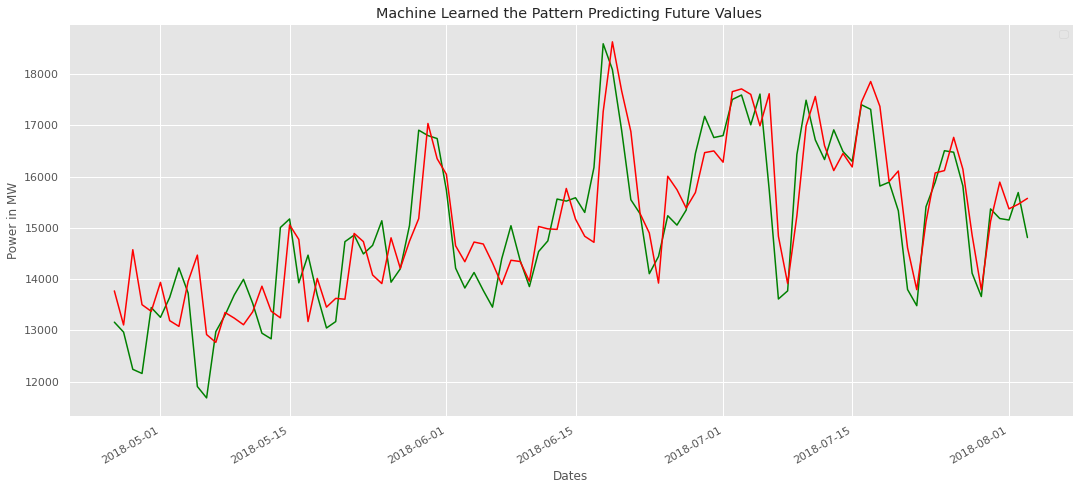

In [74]:
fig = plt.figure()

ax1= fig.add_subplot(111)

x = dates
y = True_MegaWatt

y1 = Predicted_MegaWatt

plt.plot(x,y, color="green")
plt.plot(x,y1, color="red")
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.xlabel('Dates')
plt.ylabel("Power in MW")
plt.title("Machine Learned the Pattern Predicting Future Values ")
plt.legend()

Green shows actual and red shows predicted. The difference between them is our error.